In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import scipy.stats as ss

In [2]:
plt.style.use('default')
plt.rcParams.update({"axes.grid" : True})

In [3]:
%reload_ext autoreload
%autoreload 2

## Gamma distribution

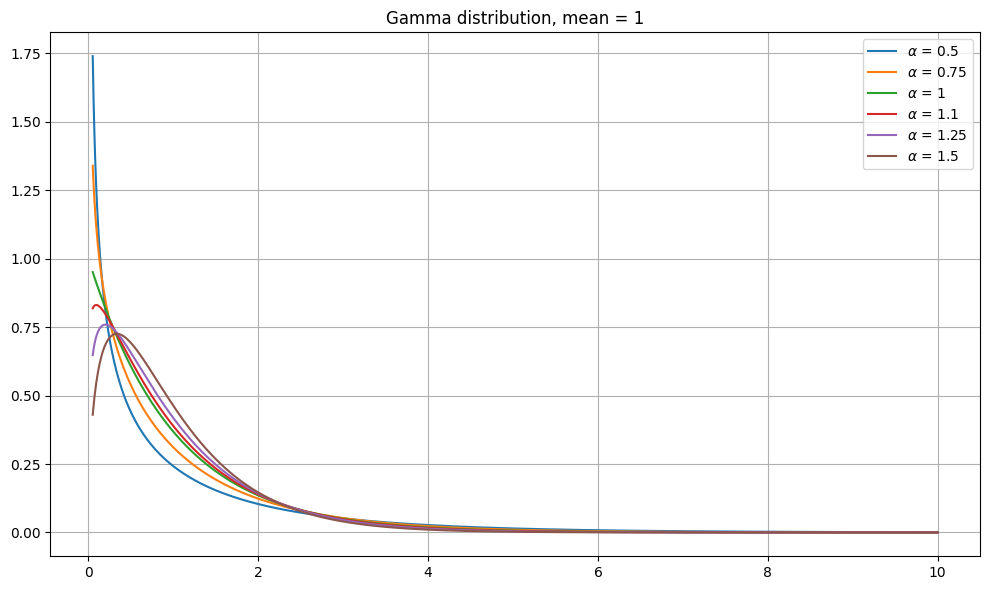

In [4]:
# simulate gamma with constant mean
np.random.seed(1)

fig, ax = plt.subplots(figsize=(10, 6))

alphas = [0.5, 0.75, 1, 1.1, 1.25, 1.5]
for alpha in alphas:
    beta = alpha

    dist = ss.gamma(a=alpha, scale=1/beta)
    xs = np.linspace(0.05, 10, 1000)
    ys = dist.pdf(xs)
    plt.plot(xs, ys, label=f"$\\alpha$ = {alpha}")

plt.legend()
plt.title('Gamma distribution, mean = 1')
fig.tight_layout();

should put alpha < 1 for mode at 0

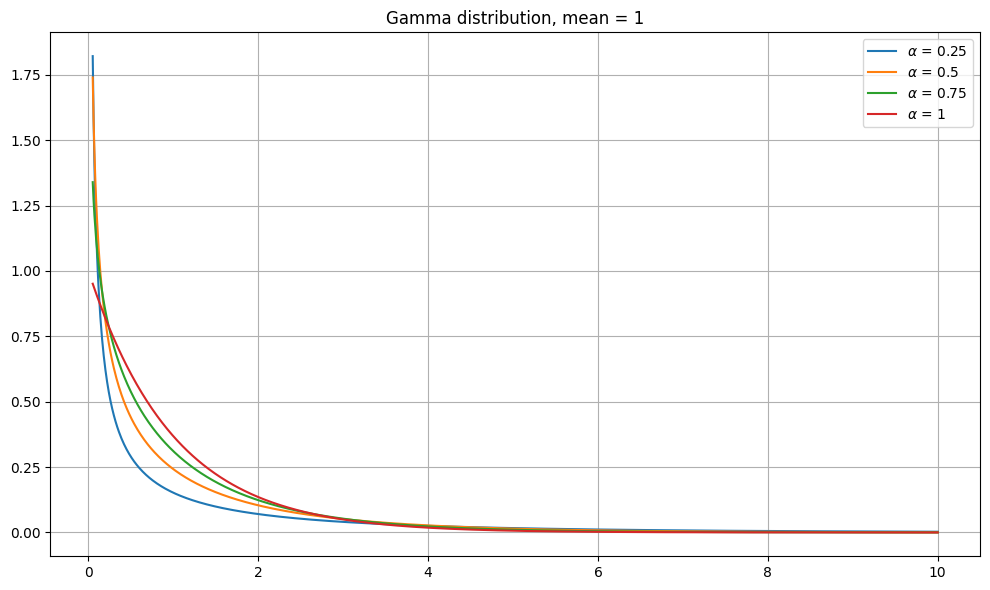

In [5]:
# simulate gamma with constant mean
np.random.seed(1)

fig, ax = plt.subplots(figsize=(10, 6))

alphas = [0.25, 0.5, 0.75, 1]
for alpha in alphas:
    beta = alpha

    dist = ss.gamma(a=alpha, scale=1/beta)
    xs = np.linspace(0.05, 10, 1000)
    ys = dist.pdf(xs)
    plt.plot(xs, ys, label=f"$\\alpha$ = {alpha}")

plt.legend()
plt.title('Gamma distribution, mean = 1')
fig.tight_layout();

In [6]:
results_df = []
for alpha in alphas:
    beta = alpha
    mean, var, skew, kurt = ss.gamma(a=alpha, scale=1/beta).stats(moments='mvsk')
    results_df.append([alpha, beta, mean, var, skew, kurt])
results_df = pd.DataFrame(results_df, columns=['alpha', 'beta', 'mean', 'var', 'skew', 'kurt'])
results_df

,alpha,beta,mean,var,skew,kurt
0,0.25,0.25,1.0,4.000000,4.000000,24.0
1,0.50,0.50,1.0,2.000000,2.828427,12.0
2,0.75,0.75,1.0,1.333333,2.309401,8.0
3,1.00,1.00,1.0,1.000000,2.000000,6.0


## Skewness and Kurtosis

from https://gist.github.com/paddymccrudden/de5ab688b0d93e204098f03ccc211d88

In [7]:
import numpy as np
from numpy.linalg import solve
from scipy.stats import moment,norm

def fleishman(b, c, d):
    """calculate the variance, skew and kurtois of a Fleishman distribution
    F = -c + bZ + cZ^2 + dZ^3, where Z ~ N(0,1)
    """
    b2 = b * b
    c2 = c * c
    d2 = d * d
    bd = b * d
    var = b2 + 6*bd + 2*c2 + 15*d2
    skew = 2 * c * (b2 + 24*bd + 105*d2 + 2)
    ekurt = 24 * (bd + c2 * (1 + b2 + 28*bd) + 
                 d2 * (12 + 48*bd + 141*c2 + 225*d2))
    return (var, skew, ekurt)

def flfunc(b, c, d, skew, ekurtosis):
    """
    Given the fleishman coefficients, and a target skew and kurtois
    this function will have a root if the coefficients give the desired skew and ekurtosis
    """
    x,y,z = fleishman(b,c,d)
    return (x - 1, y - skew, z - ekurtosis)

def flderiv(b, c, d):
    """
    The deriviative of the flfunc above
    returns a matrix of partial derivatives
    """
    b2 = b * b
    c2 = c * c
    d2 = d * d
    bd = b * d
    df1db = 2*b + 6*d
    df1dc = 4*c
    df1dd = 6*b + 30*d
    df2db = 4*c * (b + 12*d)
    df2dc = 2 * (b2 + 24*bd + 105*d2 + 2)
    df2dd = 4 * c * (12*b + 105*d)
    df3db = 24 * (d + c2 * (2*b + 28*d) + 48 * d**3)
    df3dc = 48 * c * (1 + b2 + 28*bd + 141*d2)
    df3dd = 24 * (b + 28*b * c2 + 2 * d * (12 + 48*bd + 
                  141*c2 + 225*d2) + d2 * (48*b + 450*d))
    return np.matrix([[df1db, df1dc, df1dd],
                      [df2db, df2dc, df2dd],
                      [df3db, df3dc, df3dd]])

def newton(a, b, c, skew, ekurtosis, max_iter=25, converge=1e-5):
    """Implements newtons method to find a root of flfunc."""
    f = flfunc(a, b, c, skew, ekurtosis)
    for i in range(max_iter):
        if max(map(abs, f)) < converge:
            break
        J = flderiv(a, b, c)
        delta = -solve(J, f)
        (a, b, c) = delta + (a,b,c)
        f = flfunc(a, b, c, skew, ekurtosis)
    return (a, b, c)


def fleishmanic(skew, ekurt):
    """Find an initial estimate of the fleisman coefficients, to feed to newtons method"""
    c1 = 0.95357 - 0.05679 * ekurt + 0.03520 * skew**2 + 0.00133 * ekurt**2
    c2 = 0.10007 * skew + 0.00844 * skew**3
    c3 = 0.30978 - 0.31655 * c1
    return (c1, c2, c3)


def fit_fleishman_from_sk(skew, ekurt):
    """Find the fleishman distribution with given skew and ekurtosis
    mean =0 and stdev =1
    
    Returns None if no such distribution can be found
    """
    if ekurt < -1.13168 + 1.58837 * skew**2:
        return None
    a, b, c = fleishmanic(skew, ekurt)
    coef = newton(a, b, c, skew, ekurt)
    return coef

def describe(data):
    """Return summary statistics of as set of data"""
    mean = sum(data)/len(data)
    var = moment(data,2)
    skew = moment(data,3)/var**1.5
    kurt = moment(data,4)/var**2
    return (mean,var,skew,kurt)

def generate_fleishman(a,b,c,d,N=100):
    """Generate N data items from fleishman's distribution with given coefficents"""
    Z = norm.rvs(size=N)
    F = a + Z*(b +Z*(c+ Z*d))
    return F

check if works...

In [8]:
mean = 0.1
std = 0.15
skew = 1
ekurt = 6-1  # because the method overestimates it
coeff = fit_fleishman_from_sk(skew, ekurt)
assert coeff is not None

In [9]:
np.random.seed(1)
B = 10000
xs = (generate_fleishman(-coeff[1], *coeff, N=B))*std+mean
# xs = ss.norm(loc=mean, scale=std).rvs(B)

In [10]:
# calculate mean, var, skew, excessive kurtosis
pd.Series(xs).agg(['mean', 'std', 'skew', 'kurt'])

mean    0.101677
std     0.151321
skew    1.207699
kurt    6.118482
dtype: float64

simulate different skew, kurt

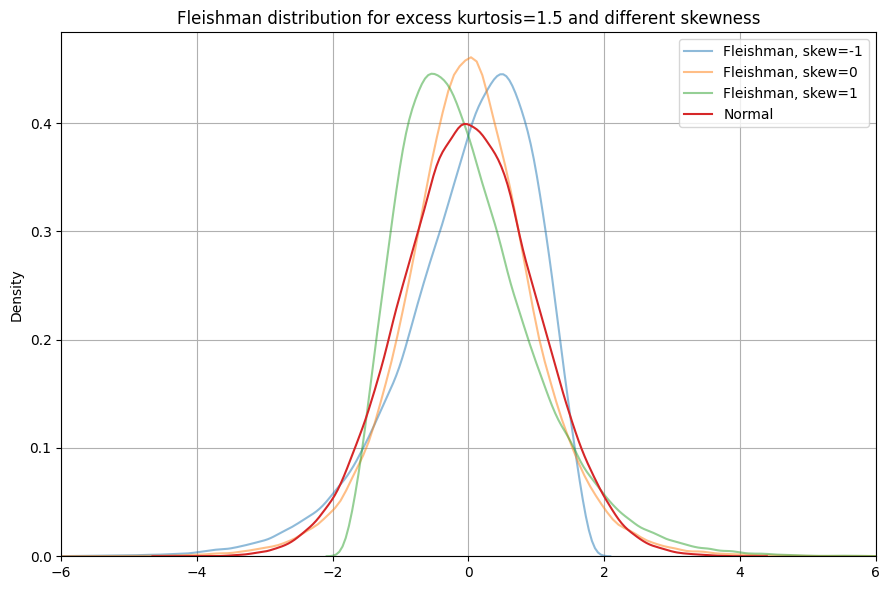

In [11]:
np.random.seed(2)
B = 100000

fig, axs = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

mean = 0
std = 1
skews = [-1, 0, 1]
kurt = 1.5
for i, skew in enumerate(skews):
    plt.sca(axs)
    coeff = fit_fleishman_from_sk(skew, kurt)
    assert coeff is not None, f'no solution for skew={skew}, kurt={kurt}'
    xs = (generate_fleishman(-coeff[1], *coeff, N=B))*std+mean
    sns.kdeplot(xs, label=f'Fleishman, skew={skew}', alpha=0.5)
    plt.xlim(-6+mean, 6+mean)

plt.title('Fleishman distribution for excess kurtosis=1.5 and different skewness')
xs = ss.norm(loc=mean, scale=std).rvs(B)
sns.kdeplot(xs, label='Normal')
plt.legend()
plt.tight_layout()
plt.savefig(f"./plots/fleish_skew.png");

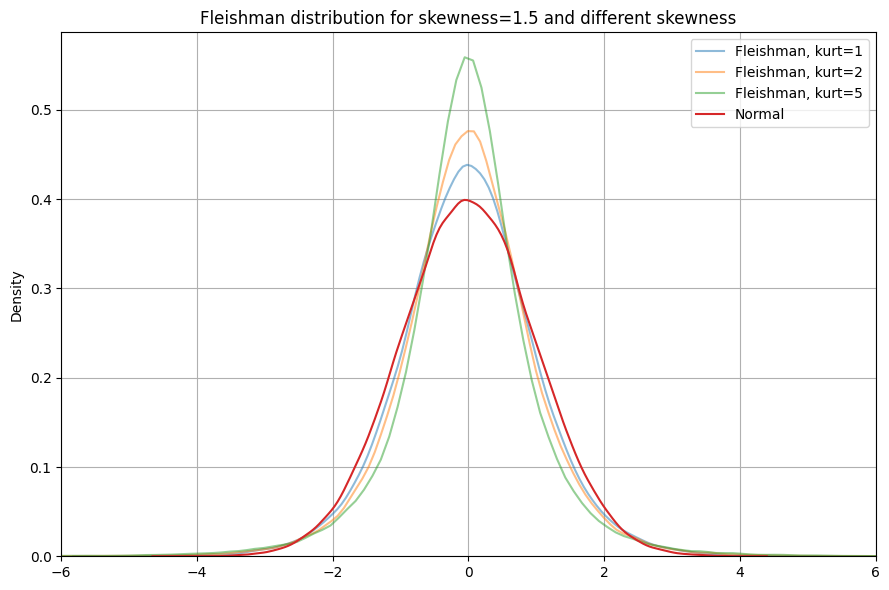

In [12]:
np.random.seed(2)
B = 100000

fig, axs = plt.subplots(1, 1, figsize=(9, 6), sharex=True)

mean = 0
std = 1
skew = 0
kurts = np.array([2, 3, 6]) - 1
for i, kurt in enumerate(kurts):
    plt.sca(axs)
    coeff = fit_fleishman_from_sk(skew, kurt)
    assert coeff is not None, f'no solution for skew={skew}, kurt={kurt}'
    xs = (generate_fleishman(-coeff[1], *coeff, N=B))*std+mean
    sns.kdeplot(xs, label=f'Fleishman, kurt={kurt}', alpha=0.5)
    plt.xlim(-6+mean, 6+mean)

plt.title('Fleishman distribution for skewness=1.5 and different skewness')
xs = ss.norm(loc=mean, scale=std).rvs(B)
sns.kdeplot(xs, label='Normal')
plt.legend()
plt.tight_layout()

plt.savefig(f"./plots/fleish_kurt.png");

## Innovations

Run the Haircut SR with different innovations

In [13]:
# https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [14]:
from adjustment_main import run_adjustment, Haircut_SR
from plots import plot_sr

In [15]:
crosssec_rho=0
autocorrelation=0

skew = 1
kurt = 3
dist_innovations = 'fleish'
dist_innovations_params = {'skew': skew, 'kurt': kurt}
file_prefix = f'fleish_{skew}_{kurt}_'

In [22]:
np.random.seed(1)
for num_tests in tqdm([10, 50, 200]):
    srs = np.linspace(0.2, 1.1, 16)
    results = []

    for idx, sr in enumerate(srs):
        # res is p_arr, sr_arr, haircut_arr
        res = Haircut_SR(
            sample_freq=3,
            num_obs=240,
            SR=sr,
            is_annualised=True,
            is_autocorrelated=False,
            autocorrelation=autocorrelation,
            num_test=num_tests,
            crosssec_rho=crosssec_rho,
            sample_dist_innovations=dist_innovations,
            sample_innovations_params=dist_innovations_params,
        )
        results.append(res)
    results = np.array(results)
    plot_sr(
        srs, results, crosssec_rho=crosssec_rho,
        autocorrelation=autocorrelation,
        num_test=num_tests, file_prefix=file_prefix
    )

  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

  0%|          | 0/3 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

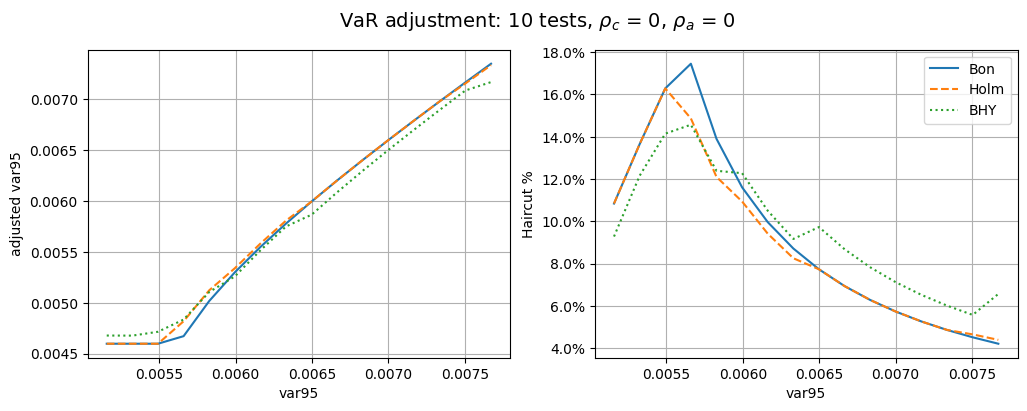

<Figure size 640x480 with 0 Axes>

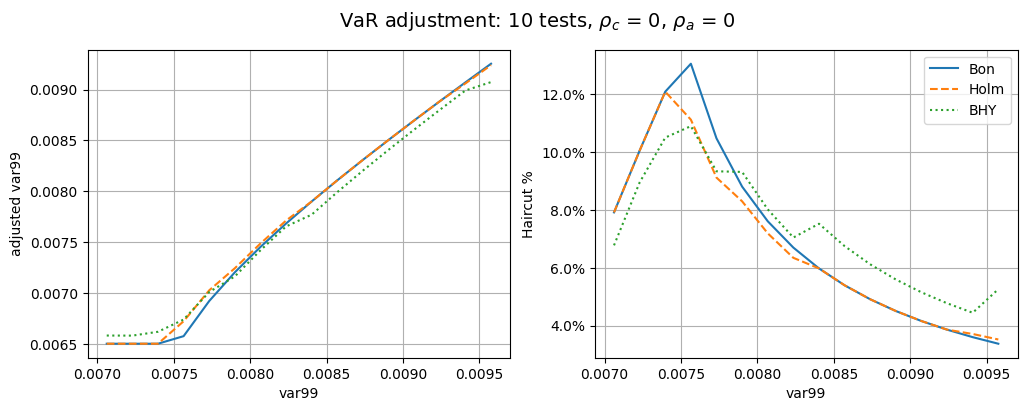

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

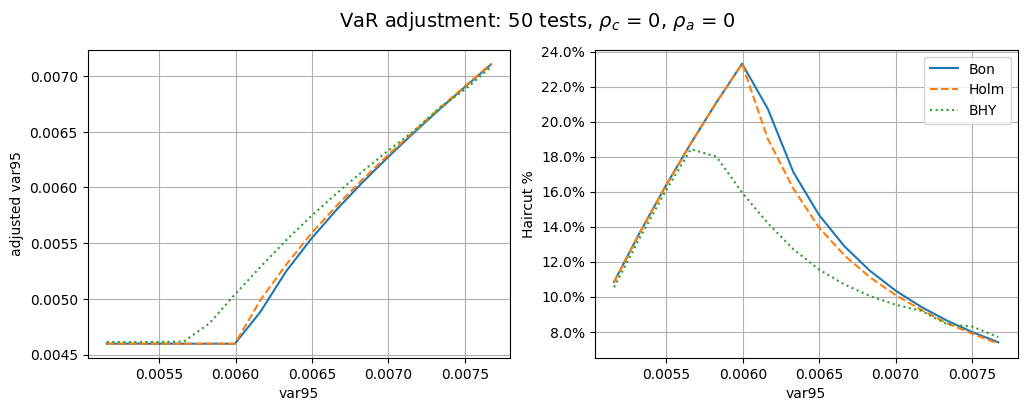

<Figure size 640x480 with 0 Axes>

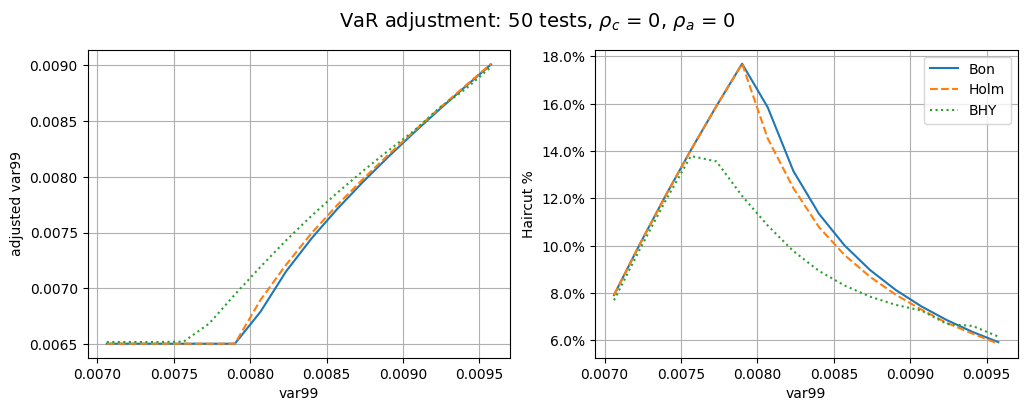

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

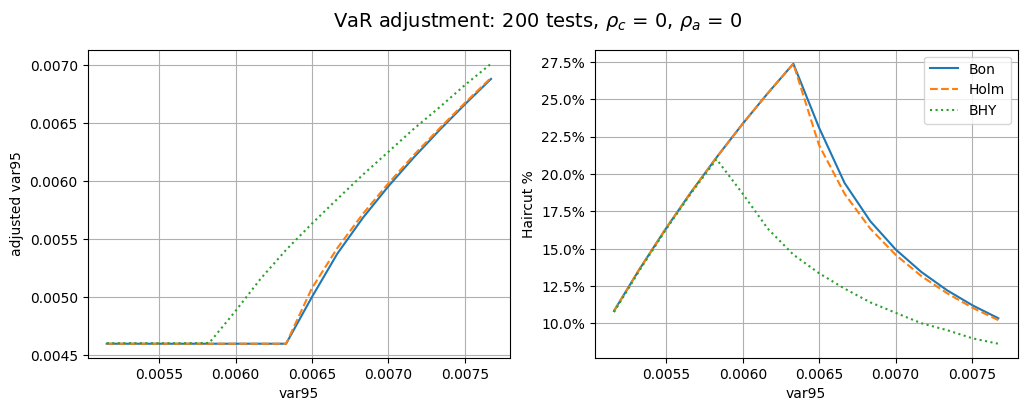

<Figure size 640x480 with 0 Axes>

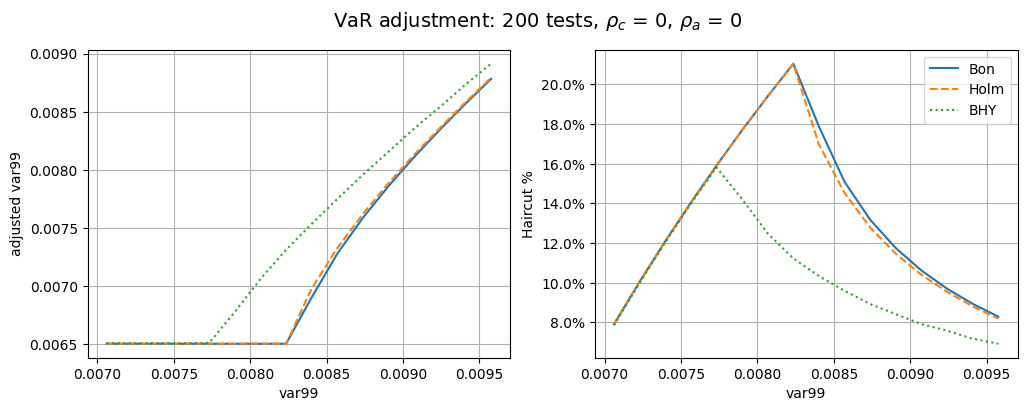

<Figure size 640x480 with 0 Axes>

In [21]:
# adjustments main
np.random.seed(1)
for num_tests in tqdm([10, 50, 200]):
    run_adjustment(crosssec_rho=0, autocorrelation=0, num_test=num_tests)

## PSR

Here we calculate the PSR

In [25]:
from adjustment_main import get_sr_std, get_psr

In [27]:
# assume T = 360 days
T = 360
srs = np.linspace(0.2, 1.1, 16)
skews = np.linspace(-1, 1, 3)

haircut depending on skew

/Users/th/Documents/ICL/Portfolio Management/portfolio_management_cw/charvey/adjustment_main.py:17: RuntimeWarning: invalid value encountered in sqrt
  # Parameter input from Harvey, Liu and Zhu (2014)


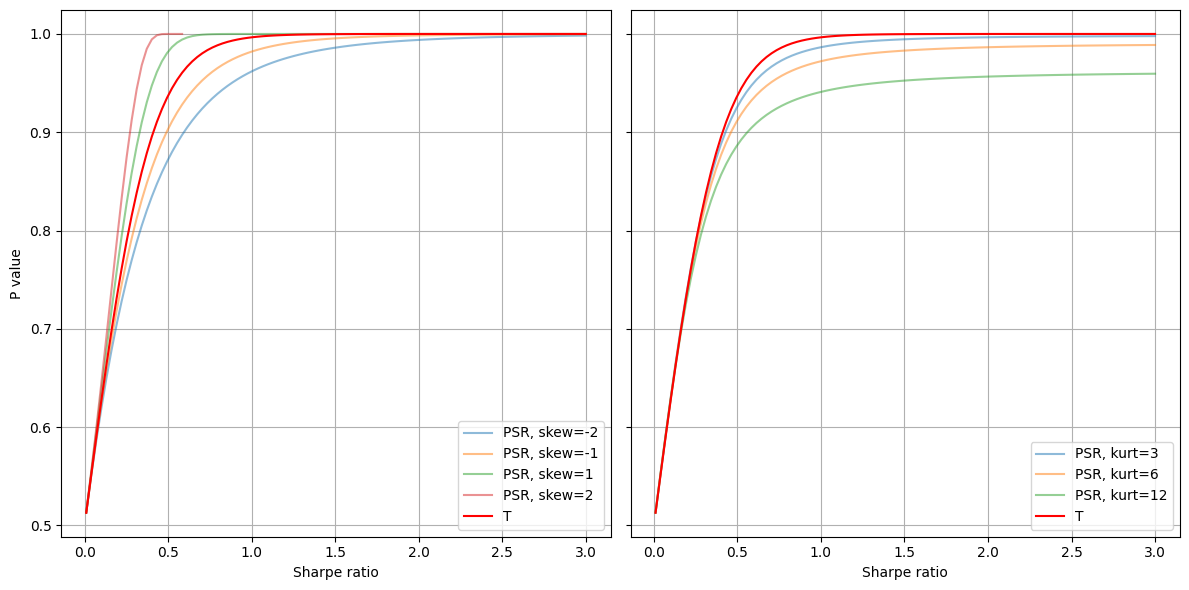

In [107]:
T = 12  # months

srs = np.linspace(0.01, 3, 100)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

plt.sca(axs[0])
skews = [-2, -1, 1, 2]
kurt = 0
for skew in skews:
    srs_stds = get_sr_std(srs, skew, kurt+3, T)
    psrs = get_psr(srs, skew, kurt+3, T)

    haircut_pvals = ss.norm.cdf(srs/srs_stds)
    plt.plot(srs, haircut_pvals, label=f'PSR, skew={skew}', alpha=0.5)

# normal t-stat approx
t_stat = srs * np.sqrt(T-1)
t_pvals = ss.t.cdf(t_stat, T-1)

plt.plot(srs, t_pvals, label='T', color='red')
plt.xlabel('Sharpe ratio')
plt.ylabel("P value")
plt.legend()

plt.sca(axs[1])
skew = 0
kurts = [3, 6, 12]
for kurt in kurts:
    srs_stds = get_sr_std(srs, skew, kurt+3, T)
    psrs = get_psr(srs, skew, kurt+3, T)

    haircut_pvals = ss.norm.cdf(srs/srs_stds)
    plt.plot(srs, haircut_pvals, label=f'PSR, kurt={kurt}', alpha=0.5)

# normal t-stat approx
t_stat = srs * np.sqrt(T-1)
t_pvals = ss.t.cdf(t_stat, T-1)

plt.plot(srs, t_pvals, label='T', color='red')
plt.xlabel('Sharpe ratio')
plt.legend()

fig.tight_layout()
plt.savefig(f"./plots/PSR_pvals.png");